In [71]:
# default_exp tearsheets

In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
# export

import pyfolio
from pyfolio.timeseries import perf_stats, gen_drawdown_table
import numpy as np
import pandas as pd
from path import Path
from pprint import pprint
from functools import reduce
import datetime
import logging
import re

import simplejson as json

from mlbt.historical_bt import simulate_pnl
from mlbt.pnl_sim import get_pnl_reports

try:
    from mlbt import settings_pers as settings
except:
    from mlbt import settings

FORMAT = "%(asctime)-15s %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

def mean_of_dfs(dfs):
    return reduce(lambda left, right: left.add(right), dfs) / len(dfs)

def make_default_config(**data):
    DATA_DIR = data.get("DATA_DIR", settings.DATA_DIR)

    return {
        "DATA_DIR": DATA_DIR,
        "F_PAYLOAD_DIR": data.get("F_PAYLOAD_DIR", settings.F_PAYLOAD_DIR),
        "symbols_map": pd.read_csv(DATA_DIR / "symbols.csv", index_col="iqsymbol")
    }


def create_frontend_payload_multi(file_names, force=False, our_config=None):
    if our_config is None:
        our_config = make_default_config()

    new_file_name = our_config["F_PAYLOAD_DIR"] / "f_payload_MULTI.json"

    
def abort_early(force, file_name):
    have_file = False
    if not force:
        try:
            # Check if we already have the file we want to create
            with open(file_name) as f:
                have_file = bool(json.load(f))
        except:
            pass
        if have_file:
            return True
    return False
    


def load_payloads(file_names, our_config):
    res = []
    for file_name in file_names:
        with open(file_name) as f:
            pay_j = json.load(f)

        events = pd.DataFrame.from_dict(pay_j["events"])
        events = events.set_index(pd.to_datetime(events.index))
        events["t1"] = pd.to_datetime(events["t1"])
        config = get_config(pay_j, file_name)
        config = {**config, **our_config}

        closes, clf_signals, alpha_signals = get_pnl_reports(
            events,
            pay_j["symbols"],
            config["binarize"],
            config["binarize_params"],
        )
        logging.info(f"clf_signals shape {clf_signals.shape}")

        primary_signals, secondary_signals = (
            (alpha_signals, clf_signals)
            if alpha_signals is not None
            else (clf_signals, alpha_signals)
        )
        res.append((config, pay_j, closes, primary_signals, secondary_signals))

    return res

def join_signals(dfs):
    cols = dfs[0].columns
    signals = []
    for col in cols:
        symbol_signals = pd.concat([df[col] for df in dfs if col in df], axis=1).ffill().mean(axis=1)
        signals.append(symbol_signals)
    res = pd.concat(signals, axis=1).ffill()
    res.columns = cols
    return res


def create_frontend_payload(file_names, force=False, our_config=None):
    if our_config is None:
        our_config = make_default_config()
    
    combine_multi = len(file_names) > 1
    if combine_multi:
        new_file_name = our_config["F_PAYLOAD_DIR"] / f"f_payload_MULTI_{len(file_names)}.json"
    else:
        new_file_name = our_config["F_PAYLOAD_DIR"] / file_names[0].basename().replace("payload_", "f_payload_", 1)
    
    if abort_early(force, new_file_name):
        return
    
    payloads = load_payloads(file_names, our_config)
    configs, pay_js, closes, primary_signals, secondary_signals = zip(*payloads)
    config = configs[0]
    pay_j = pay_js[0]
    closes = closes[0]
    primary_signals = join_signals(primary_signals)
    
    if secondary_signals[0]:
        secondary_signals = join_signals(secondary_signals)
    
    primary_rets, pay_j["primary"]["pnl"] = create_tearsheet(
        config, closes, primary_signals, new_file_name, "primary"
    )
    if pay_j["secondary"]:
        _, pay_j["secondary"]["pnl"] = create_tearsheet(
            config, closes, secondary_signals, new_file_name, "secondary", primary_rets
        )

    # Delete stuff we don't want in the frontend payload
    del pay_j["events"]
    del pay_j["symbols"]

    logging.info(f"Writing f_payload at {new_file_name}")
    with open(new_file_name, "w") as f:
        json.dump(pay_j, f, ignore_nan=True, default=datetime.datetime.isoformat)
    return new_file_name

    

def calc_returns(df):
    df = df.resample("1B").last()

    if str(df.index.tz) != "UTC":
        df.index = df.index.tz_localize(tz="UTC")

    return df.pct_change()

def create_tearsheet(config, close, signal, file_name, report_type, benchmark_rets=None):
    logging.info(f"Creating {report_type} tearsheet for {file_name}")
    # Due to our train/test split we have few symbols at the beginning of our data sets

    # Map long/short to long/flat
    signal = (signal + 1) / 2
    pos_size = 50000
    df_net, _, cost_stats = simulate_pnl(config, close, signal, pos_size)
    returns_net = calc_returns(df_net)
    returns_net.name = report_type.title()

    if report_type == "primary":
        long_all = pd.DataFrame(1, columns=signal.columns, index=signal.index)
        df_bench, _, _ = simulate_pnl(config, close, long_all, pos_size)
        benchmark_rets = calc_returns(df_bench)
        benchmark_rets.name = "Benchmark (long all)"

    fig = pyfolio.create_returns_tear_sheet(
        returns_net,
        benchmark_rets=benchmark_rets,
        return_fig=True
    )
    fig_file_name = file_name.replace(".json", f"_{report_type}.png")
    fig.savefig(fig_file_name, bbox_inches="tight", pad_inches=0)

    p_stats = perf_stats(returns_net)
    dd_table = gen_drawdown_table(returns_net, 5)

    signal = signal.resample("1B").last()
    # Just-in-case normalize to 1 for reporting
    signal = signal / signal.max().max()
    signal.plot()
    signal = signal.set_index(signal.index.map(lambda x: x.isoformat()))
    

    return (
        returns_net,
        {
            "fig_file_name": str(Path(fig_file_name).basename()),
            "p_stats": p_stats.to_dict(),
            "dd_table": dd_table.to_dict(),
            "signal": signal.to_csv(),  # CSV is a lot more space-efficient for this dense 1500*50 table
            "cost_stats": cost_stats,
        },
    )


def get_config(payload, fn):
    if "config" in payload:
        return payload["config"]

    # bridge to the old payload format
    if "fixed_horizon" in fn:
        return {
            "binarize": "fixed_horizon",
            "binarize_params": int(re.findall(r"fixed_horizon_(\d+)", fn)[0]),
        }
    return {}

In [74]:

from mlbt.settings_pers import *

import json
fns = [DATA_DIR / 'payloads/payload_agriculture-currency-energy-equity_index-interest_rate-metals_dollar_fixed_horizon_200_none_[]_lgbm.json']

our_config = make_default_config()


In [75]:
plds = load_payloads(fns, our_config)

2020-02-22 14:04:35,366 Generating signals for 47 symbols on 394728 events with b_params=200
2020-02-22 14:04:36,535 clf_signals shape (394728, 47)


In [10]:
pld = plds[0]

In [12]:
config, pay_j, closes, primary_signals, secondary_signals = pld

In [65]:
signal = primary_signals + 1 / 2
signal = primary_signals

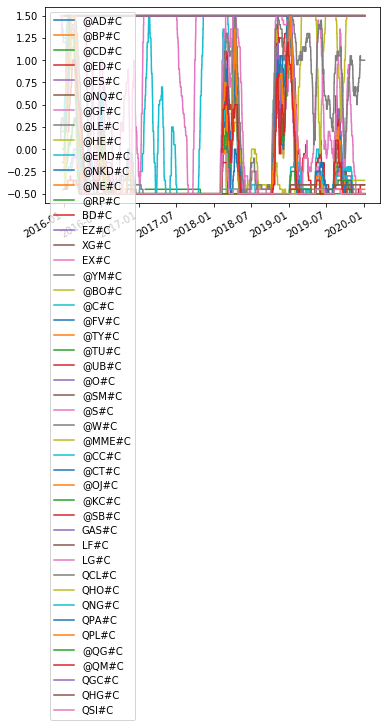

In [61]:
signal.plot()

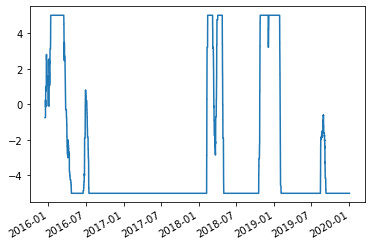

In [69]:
columns = signal.shape[1]
max_long = columns // 2
max_long = 5
signal_sums = signal.fillna(0).sum(axis=1).abs()
adjustor = ((signal_sums - max_long).clip(0, 100) / signal_sums)

(signal.fillna(0).sum(axis=1) * (1 - adjustor)).plot()

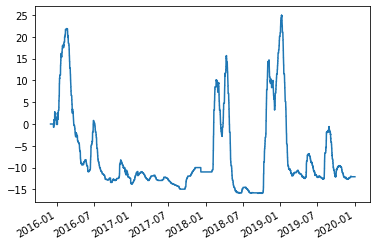

In [67]:
signal_sums.plot()

In [114]:
config

{'DATA_DIR': Path('C:\\Users\\doda/Dropbox/algotrading/data'),
 'F_PAYLOAD_DIR': Path('C:\\Users\\doda/pr/fincl/frontend/public/payloads'),
 'start_date': '2000-01-01',
 'end_date': '2021-01-01',
 'data_freq': 'minutely',
 'downsampling': 'cusum',
 'vol_estimate': 100,
 'symbols': None,
 'symbol_groups': ['agriculture',
  'currency',
  'energy',
  'equity_index',
  'interest_rate',
  'metals'],
 'features': [{'name': 'log_ret'},
  {'name': 'close', 'symbol': 'VIX.XO'},
  {'name': 'ffd', 'd': 0.5},
  {'name': 'roll', 'window': 10},
  {'name': 'rollimp', 'window': 10},
  {'name': 'amihud', 'window': 10},
  {'name': 'kyle', 'window': 10},
  {'name': 'ewm_mean', 'window': 10, 'symbol': {'name': 'volratio'}},
  {'name': 'roll', 'window': 25},
  {'name': 'rollimp', 'window': 25},
  {'name': 'amihud', 'window': 25},
  {'name': 'kyle', 'window': 25},
  {'name': 'ewm_mean', 'window': 25, 'symbol': {'name': 'volratio'}},
  {'name': 'roll', 'window': 50},
  {'name': 'rollimp', 'window': 50},
  {'

In [116]:
closes

,@AD#C,@BP#C,@CD#C,@ED#C,@ES#C,@NQ#C,@GF#C,@LE#C,@HE#C,@EMD#C,...,QCL#C,QHO#C,QNG#C,QPA#C,QPL#C,@QG#C,@QM#C,QGC#C,QHG#C,QSI#C
2015-04-24 07:50:00.000035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-24 07:55:00.000033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-24 07:56:00.000046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.574
2015-04-24 08:01:00.000043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,77.36,NaN,NaN,17.574
2015-04-24 08:07:00.000031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,77.36,NaN,NaN,17.574
2015-04-24 08:07:00.000037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78.33,NaN,NaN,NaN,NaN,NaN,77.36,NaN,NaN,17.574
2015-04-24 08:10:00.000013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78.33,NaN,NaN,NaN,NaN,NaN,77.36,NaN,NaN,17.574
2015-04-24 08:16:00.000029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78.33,NaN,NaN,NaN,NaN,NaN,77.36,NaN,NaN,17.574
2015-04-24 08:26:00.000020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78.33,NaN,NaN,NaN,NaN,NaN,77.36,NaN,NaN,17.574
2015-04-24 08:26:00.000031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78.33,NaN,NaN,NaN,NaN,NaN,77.36,NaN,NaN,17.574


In [119]:
close = closes
vols = [ for x in close.columns]

In [127]:
vols

,@AD#C,@BP#C,@CD#C,@ED#C,@ES#C,@NQ#C,@GF#C,@LE#C,@HE#C,@EMD#C,...,QCL#C,QHO#C,QNG#C,QPA#C,QPL#C,@QG#C,@QM#C,QGC#C,QHG#C,QSI#C
2015-04-24 07:50:00.000035,0.009884,0.005674,0.007532,0.000341,0.004609,0.004023,0.008511,0.009563,0.010518,0.004139,...,0.010672,0.013151,0.014462,0.006068,0.006836,0.034847,0.014518,0.004469,0.009717,0.006962
2015-04-24 07:55:00.000033,0.009884,0.005674,0.007532,0.000341,0.004609,0.004023,0.008511,0.009563,0.010518,0.004139,...,0.010672,0.013151,0.014462,0.006068,0.006836,0.034847,0.014518,0.004469,0.009717,0.006962
2015-04-24 07:56:00.000046,0.009884,0.005674,0.007532,0.000341,0.004609,0.004023,0.008511,0.009563,0.010518,0.004139,...,0.010672,0.013151,0.014462,0.006068,0.006836,0.034847,0.014518,0.004469,0.009717,0.006962
2015-04-24 08:01:00.000043,0.009884,0.005674,0.007532,0.000341,0.004609,0.004023,0.008511,0.009563,0.010518,0.004139,...,0.010672,0.013151,0.014462,0.006068,0.006836,0.034847,0.014518,0.004469,0.009717,0.006962
2015-04-24 08:07:00.000031,0.009884,0.005674,0.007532,0.000341,0.004609,0.004023,0.008511,0.009563,0.010518,0.004139,...,0.010672,0.013151,0.014462,0.006068,0.006836,0.034847,0.014518,0.004469,0.009717,0.006962
2015-04-24 08:07:00.000037,0.009884,0.005674,0.007532,0.000341,0.004609,0.004023,0.008511,0.009563,0.010518,0.004139,...,0.010672,0.013151,0.014462,0.006068,0.006836,0.034847,0.014518,0.004469,0.009717,0.006962
2015-04-24 08:10:00.000013,0.009884,0.005674,0.007532,0.000341,0.004609,0.004023,0.008511,0.009563,0.010518,0.004139,...,0.010672,0.013151,0.014462,0.006068,0.006836,0.034847,0.014518,0.004469,0.009717,0.006962
2015-04-24 08:16:00.000029,0.009884,0.005674,0.007532,0.000341,0.004609,0.004023,0.008511,0.009563,0.010518,0.004139,...,0.010672,0.013151,0.014462,0.006068,0.006836,0.034847,0.014518,0.004469,0.009717,0.006962
2015-04-24 08:26:00.000020,0.009884,0.005674,0.007532,0.000341,0.004609,0.004023,0.008511,0.009563,0.010518,0.004139,...,0.010672,0.013151,0.014462,0.006068,0.006836,0.034847,0.014518,0.004469,0.009717,0.006962
2015-04-24 08:26:00.000031,0.009884,0.005674,0.007532,0.000341,0.004609,0.004023,0.008511,0.009563,0.010518,0.004139,...,0.010672,0.013151,0.014462,0.006068,0.006836,0.034847,0.014518,0.004469,0.009717,0.006962


In [128]:
signal

,@AD#C,@BP#C,@CD#C,@ED#C,@ES#C,@NQ#C,@GF#C,@LE#C,@HE#C,@EMD#C,...,QCL#C,QHO#C,QNG#C,QPA#C,QPL#C,@QG#C,@QM#C,QGC#C,QHG#C,QSI#C
2015-04-24 07:50:00.000035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-24 07:55:00.000033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-24 07:56:00.000046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-24 08:01:00.000043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-24 08:07:00.000031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-24 08:07:00.000037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-24 08:10:00.000013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-24 08:16:00.000029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-24 08:26:00.000020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-24 08:26:00.000031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
(50000 * signal / vols)


,@AD#C,@BP#C,@CD#C,@ED#C,@ES#C,@NQ#C,@GF#C,@LE#C,@HE#C,@EMD#C,...,QCL#C,QHO#C,QNG#C,QPA#C,QPL#C,@QG#C,@QM#C,QGC#C,QHG#C,QSI#C
2015-04-24 07:50:00.000035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-24 07:55:00.000033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-24 07:56:00.000046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-24 08:01:00.000043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-24 08:07:00.000031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-24 08:07:00.000037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-24 08:10:00.000013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-24 08:16:00.000029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-24 08:26:00.000020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-24 08:26:00.000031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
